**Ομάδα**


> *Δημήτρης Κοκκίνης 03118896*


> *Χριστίνα Ρεντίφη 03118217*







#Αναγνώριση Προτύπων
**1η Εργαστηριακή Άσκηση** 

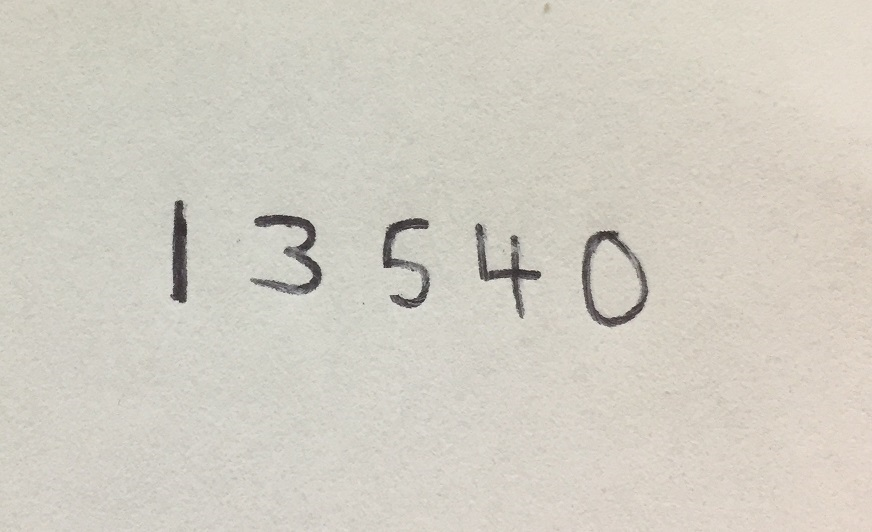






*Περιγραφή Εργαστηρίου:*



> Σκοπός είναι η υλοποίηση ενός συστήματος **οπτικής αναγνώρισης ψηφίων**, δηλαδή ταξινόμησης εικόνων που περιέχουν χειρόγραφα σκίτσα ψηφίων από το 0 ως το 9, σε δέκα κατηγορίες ανάλογα με το ψηφίο που απεικονίζουν.

Μας δίνονται τα δεδομένα σε δύο αρχεία text, όπου είναι σε μορφή πίνακα. Κάθε γραμμή αντιστοιχεί σε ένα απο τα ψηφία 0 έως 9 και κάθε στήλη περιέχει τα χαρακτηριστικά (features) του κάθε ψηφίου, τα οποία χαρακτηριστικά είναι τιμές grayscale.

Θα εφαρμόσουμε supervised learning δοκιμάζοντας διαφορετικά μοντέλα και συνδυασμούς αυτών.



Αρχικά, κάνουμε mount το drive όπου βρίσκονται τα αρχεία text και train καθώς και τις απαραίτητες βιβλιοθήκες για τον κώδικα

In [48]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

# change to lab1 directory
%cd /content/drive/MyDrive/Patterns_Labs/Lab1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Patterns_Labs/Lab1


In [49]:
# various
import numpy as np
from matplotlib import pyplot as plt
import random
import scipy.stats
import math

# sklearn 
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import KFold, learning_curve, ShuffleSplit, cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier

# pytorch
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim

Τα επόμενα 13 βήματα αποτελούν μέρος της προπαρασκευής του εργαστηρίου

**ΒΗΜΑ 1**: Διαβάστε τα δεδομένα από το αρχείο και χωρίστε τα στους πίνακες X_train, X_test, y_train, y_test

In [50]:
with open("train.txt", "r") as train_data:
    train_lines = []
    for line in train_data.readlines():
        train_lines.append(line.replace(" \n", "").replace("\n", "").split(" "))  #creating np array using data from the text files
    train_arr = np.array(train_lines)       
    X_train = np.array(train_arr[:,1:], dtype=np.float64)        #insert all elements except elements of 1st column
    y_train = np.array(train_arr[:, 0], dtype=np.float).astype(np.int64)  #insert elements of 1st column. Cannot cast directly into int64
    n_samples_train = X_train.shape[0]    #checking dimensions.Number of samples
    n_features = X_train.shape[1]         #number of features

with open("test.txt", "r") as test_data:
    test_lines = []
    for line in test_data.readlines():
        test_lines.append(line.replace(" \n", "").replace("\n", "").split(" "))
    test_arr = np.array(test_lines)
    X_test = np.array(test_arr[:,1:], dtype=np.float64)
    y_test = np.array(test_arr[:, 0], dtype=np.float).astype(np.int64)    # cannot cast directly into int64
    n_samples_test = X_test.shape[0]   #checking number of test samples

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [51]:
print('number_of_samples_train = {}'.format(n_samples_train))
print('number_of_samples_test = {}'.format(n_samples_test))
print('number_of_features = {}'.format(n_features))

number_of_samples_train = 7291
number_of_samples_test = 2007
number_of_features = 256


**ΒΗΜΑ 2**: Σχεδιάστε το υπ’ αριθμόν 131 ψηφίο



> Για το βήμα αυτό, χρησιμοποιήσαμε τη συνάρτηση reshape της numpy ώστε να οργανώσουμε τα 256 features του 131ου ψηφίου σε ένα πίνακα 16×16, όπου κάθε pixel (κελί) του πίνακα αυτού θα περιέχει το grayscale value της εικόνας του ψηφίου. Στη συνέχεια, με τη matplotlib.pyplot.imshow το εμφανίζουμε στην οθόνη.
Ως ελάχιστη και μέγιστη τιμή παίρνουμε το -1 και το 1



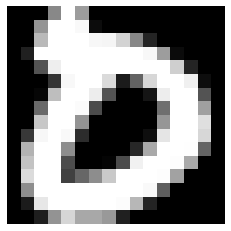

In [52]:
digit_array = X_train[130].reshape(16,16)
plt.axis('off')
plt.imshow(digit_array, cmap='gray', vmin=-1, vmax=1)
plt.show()


**ΒΗΜΑ 3**: Σχεδιάστε ένα τυχαίο δείγμα για κάθε ψηφίο



> Περιληπτικά, για κάθε ένα ψηφίο, ελέγχω όλες τις θέσεις που βρίσκεται το συγκεκριμένο label στο y_train και βάζω σε μια λίστα τα indexes αυτα. Ύστερα διαλέγω τυχαία ένα index και κάνω plot τα στοιχεία που βρίσκονται στη θέση αυτή στον X_train.



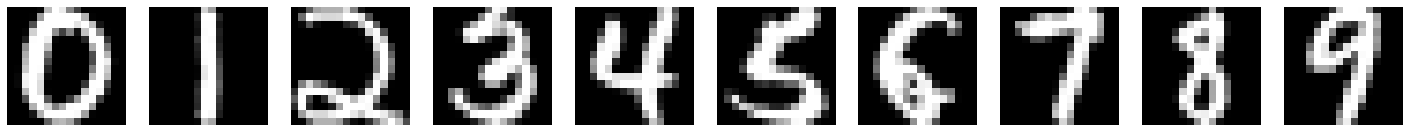

In [53]:
# Define a figure with 10 plots.
fig = plt.figure(figsize=(25,6))
columns = 10
rows = 1

for digit in range(10):
    # Pick all images of current digit
    curr_digit = []
    for j, y in enumerate(y_train):
        if y == digit:
            curr_digit.append(j)
    # Select randomly an image
    sample = X_train[random.choice(curr_digit)]
    # Display the randomly selected image in a subplot
    fig.add_subplot(rows, columns, digit+1)
    plt.axis('off')
    plt.imshow(np.reshape(sample, (16, 16)), cmap='gray', vmin=-1, vmax=1)
plt.show()

**ΒΗΜΑ 4**: Υπολογίστε τη μέση τιμή των χαρακτηριστικών του pixel (10, 10) για το ψηφίο «0» με βάση τα train δεδομένα

In [54]:
pixel = []
for j, y in enumerate(y_train):
        if y == 0:
            pixel.append(X_train[j][170])    #take the value of the 170th element of every line with label '0'

mean_value = np.mean(pixel)                  #calculate mean value
print("Mean value of pixel(10,10) of all '0' is:", mean_value)


Mean value of pixel(10,10) of all '0' is: -0.5041884422110553


**ΒΗΜΑ 5**: Υπολογίστε τη διασπορά των χαρακτηριστικών του pixel (10, 10) για το ψηφίο «0» με βάση τα train δεδομένα

In [55]:
variance = np.var(pixel)                     #calculate variance
print("Variance of values of pixel(10,10) of all '0' is:", variance)

Variance of values of pixel(10,10) of all '0' is: 0.5245221428814929


**ΒΗΜΑ 6**: Υπολογίστε τη μέση τιμή και διασπορά των χαρακτηριστικών κάθε pixel για το ψηφίο «0» με βάση τα train
δεδομένα.

In [56]:
train_size = 7291        #number of rows in train set
# Get indexes of 0's in the train set
idx_0 = [i for i in range(train_size) if y_train[i] == 0]

# Get pixels of all 0's
X_train_0 = np.take(X_train, idx_0, axis=0)
# Compute mean value along each pixel
total_mean = np.mean(X_train_0, axis=0, keepdims=True)
# Compute variance along each pixel
total_variance = np.var(X_train_0, axis=0, keepdims=True)

# Verify their shape
print("Shape of mean values: " + str(total_mean.shape))
print("Shape of variances: " + str(total_variance.shape))

Shape of mean values: (1, 256)
Shape of variances: (1, 256)


**ΒΗΜΑ 7**: Σχεδιάστε το ψηφίο «0» χρησιμοποιώντας τις τιμές της μέσης τιμής που υπολογίσατε στο Βήμα 6



> Ουσιαστικά, ακολουθούμε την ίδια διαδικασία με το βήμα 2, μόνο που εδώ χρησιμοποιούμε για κάθε pixel της εικόνας τη μέση τιμή του συγκεκριμένου pixel απο όλα τα δείγματα για το ψηφίο 0. Επομένως αυτό που παίρνουμε είναι μια μέση τιμή της εικόνας του χειρόγραφου ψηφίου '0' απο όλα τα δείγματα που διαθέτω στο train set



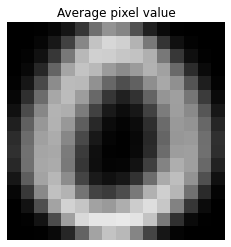

In [57]:
image_from_mean = total_mean.reshape(16,16)
plt.axis('off')
plt.title('Average pixel value')
plt.imshow(image_from_mean, cmap='gray', vmin=-1, vmax=1)
plt.show()

**ΒΗΜΑ 8**: Σχεδιάστε το ψηφίο «0» χρησιμοποιώντας τις τιμές της διασποράς που υπολογίσατε στο Βήμα 6.

*Στη συνάρτηση pyplot.imshow βάλαμε ως ελάχιστη τιμή vmin τη τιμή 0 αντί της τιμής -1 που χρησιμοποιούσαμε έτσι ώστε η εικόνα να είναι πιο καθαρή*



> Αυτό που παρατηρούμε σε αντίθεση με το βήμα 7, είναι οτι η εικόνα της μέσης τιμής των pixel περιέχει λιγότερο θόρυβο απο αυτή της διασποράς. Και στις δύο εικόνες ωστόσο το ψηφίο είναι ευδιάκριτο



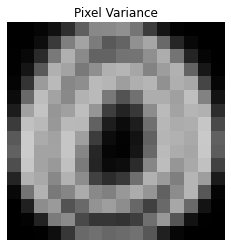

In [58]:
image_from_var = total_variance.reshape(16,16)
plt.axis('off')
plt.title('Pixel Variance')
plt.imshow(image_from_var, cmap='gray', vmin=0, vmax=1)
plt.show()

**ΒΗΜΑ 9**: Υπολογίστε τη μέση τιμή και διασπορά των χαρακτηριστικών για όλα τα ψηφία και σχεδιάστε όλα τα ψηφία χρησιμοποιώντας τις τιμές της μέσης τιμής που υπολογίσατε.



> Το βήμα αυτό αποτελεί ένα συνδυασμό όλων των προηγούμενων βημάτων. Αρχικά τοποθετούμε τις μέσες τιμές όλων των pixel για κάθε ψηφίο στον πίνακα all_mean και ύστερα κατα τα γνωστά απεικονίζουμε τα 256 αυτά features κάθε ψηφίου σε μια εικόνα




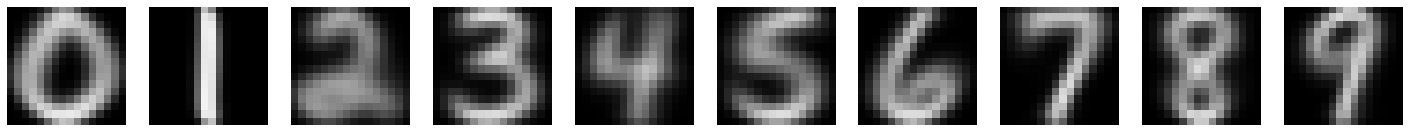

In [59]:
train_size = 7291        

all_mean = []
all_var = []
for digit in range(10):
  indx = [i for i in range(train_size) if y_train[i] == digit]

  # Get pixels for every digit
  X_train_digits = np.take(X_train, indx, axis=0)
  # Compute mean value along each pixel
  temp_mean = np.mean(X_train_digits, axis=0, keepdims=True)
  # Compute variance along each pixel
  temp_variance = np.var(X_train_digits, axis=0, keepdims=True)
  # Store mean and variance for every digit
  all_mean.append(temp_mean)
  all_var.append(temp_variance)

fig = plt.figure(figsize=(25,6))
columns = 10
rows = 1

for digit in range(10):
  # Display the image for every row of data of all_mean array
  fig.add_subplot(rows, columns, digit+1)
  plt.axis('off')
  plt.imshow(np.reshape(all_mean[digit], (16, 16)), cmap='gray', vmin=-1, vmax=1)
plt.show()

**ΒΗΜΑ 10**: Ταξινομήστε το υπ΄αριθμόν 101 ψηφίο των test δεδομένων σε μία από τις 10
κατηγορίες βάσει της Ευκλείδειας απόστασης



> Χρησιμοποιώντας τις τιμές που βρήκαμε στο ερώτημα 9α για τις μέσες τιμές κάθε κλάσης (class_means) και τη συνάρτηση euclidean_distances της sklearn υπολογίζουμε την ευκλείδεια απόσταση του test δεδομένου απο κάθε κλάση και το ταξινομούμε στη κλάση απο την οποία έχει τη μικρότερη απόσταση.
Παρατηρούμε πως το test δεδομένο ταξινομήθηκε λανθασμένα στη κλάση 0 (ως ψηφίο μηδέν) ενώ στη πραγματικότητα είναι στη κλάση 6 (είναι το ψηφίο έξι).



*Στον κώδικα χρησιμοποιώ την έτοιμη συνάρτηση της sklearn euclidean distances, ωστόσο παρακάτω παραθέτω μια εναλλακτική λύση κώδικα αντί της έτοιμης συνάρτησης αυτής:*


    for i in range(10):
      dist = np.linalg.norm(digit - all_mean[i])









Prediction for test digit No 101 is 0
The real value is 6


Image of test data No 101


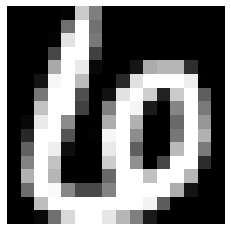

In [60]:
test_digit = np.reshape(X_test[101], (1, -1))

def predict(digit):
  dist = np.inf
  prediction = -1
  for i in range(10):
    new_dist = euclidean_distances(digit, np.reshape(all_mean[i], (1,-1)))
    if dist > new_dist:
        dist = new_dist
        prediction = i
  return prediction

print('Prediction for test digit No 101 is {}'.format(predict(test_digit)))
print('The real value is', y_test[101])
print('\n')
print('Image of test data No 101')

test_digit_array = X_test[101].reshape(16,16)
plt.axis('off') 
plt.imshow(test_digit_array, cmap='gray', vmin=-1, vmax=1)
plt.show()

**ΒΗΜΑ 11**: Ταξινομήστε όλα τα ψηφία των test δεδομένων σε μία από τις 10 κατηγορίες με βάση την Ευκλείδεια
απόσταση



> Στο βήμα αυτό ακολουθούμε τη διαδικασία του βήματος 10 για όλα τα δείγματα στο X_test και στη συνέχεια υπολογίζουμε την ακρίβεια της ταξινόμησης επι τοις εκατό




In [61]:
#2007 is the test_size
test_digits = []
for i in range(2007):
  test_digits.append(np.reshape(X_test[i], (1, -1)))

y_pred = np.zeros(2007)
for i in  range(2007):
  y_pred[i] = predict(test_digits[i])

β) Υπολογίστε το ποσοστό επιτυχίας της ταξινόμησης

In [62]:
# Count number of correct predictions and output the total accuracy.
correct = 0
for i in range(len(y_test)):
    if y_test[i] == y_pred[i]:
        correct += 1

acc = correct / len(y_test) * 100
print("Accuracy of Euclidean classifier in test set: " + str(acc) + " percent")

Accuracy of Euclidean classifier in test set: 81.41504733432984 percent


**ΒΗΜΑ 12**: Υλοποιήστε τον ταξινομητή ευκλείδειας απόστασης σαν ένα scikit-learn estimator



> Υλοποιούμε τη κλάση του ευκλείδειου ταξινομητή που βρίσκεται στη βιβλιοθήκη που δόθηκε ως βοηθητικό εργαλείο



In [63]:
class EuclideanDistanceClassifier(BaseEstimator, ClassifierMixin):
    """Classify samples based on the distance from the mean feature value"""

    def __init__(self):
        self.X_mean_ = None
        self.classes_ = None


    def fit(self, X, y):
        """
        This should fit classifier. All the "work" should be done here.
        Calculates self.X_mean_ based on the mean
        feature values in X for each class.
        self.X_mean_ becomes a numpy.ndarray of shape
        (n_classes, n_features)
        fit always returns self.
        """
        # Find the number of classes for the predictor
        self.classes_ = np.unique(y)   
        
        train_size, n_features = X.shape
        n_classes = len(self.classes_) # Number of classes
        self.X_mean_ = np.zeros((n_classes, n_features)) # Initialize array

        # Compute mean value for every class
        for m in range(n_classes):
            idx_i = [i for i in range(train_size) if y[i] == m]
            X_m = np.take(X, idx_i, axis=0)
            self.X_mean_[m, :] = np.mean(X_m, axis=0, keepdims=True)
        
        return self

    def predict(self, X):
        """
        Make predictions for X based on the
        euclidean distance from self.X_mean_
        """
        y_predict = np.argmin(euclidean_distances(X, self.X_mean_), axis=1)
        return y_predict

    def score(self, X, y):
        """
        Return accuracy score on the predictions
        for X based on ground truth y
        """
        corr = 0
        y_pred = self.predict(X)
        corr = sum(int(y[i] == y_pred[i]) for i in range(len(y)))
        acc = corr / len(y)
        return acc

**ΒΗΜΑ 13**

*α) Υπολογίστε το score του ευκλείδειου ταξινομητή με χρήση 5-fold cross-validation*




In [64]:
kf = KFold() # Define the split - into 5 folds 

edc=EuclideanDistanceClassifier()

scores = cross_val_score(edc, X_train, y_train, cv = kf.split(train_arr))
print("Score of Euclidean classifier with 5-fold cross validation: " + str(np.mean(scores)*100) + " percent")

Score of Euclidean classifier with 5-fold cross validation: 84.85803550358166 percent


β) Σχεδιάστε την περιοχή απόφασης του ευκλείδειου ταξινομητή.

In [65]:
def plot_clf(clf, X, y, labels):
    fig, ax = plt.subplots()
    # title for the plots
    title = ('Decision surface of Classifier')
    # Set-up grid for plotting.
    X0, X1 = X[:, 0], X[:, 1]
    
    x_min, x_max = X0.min() - 1, X0.max() + 1
    y_min, y_max = X1.min() - 1, X1.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .05),
                         np.arange(y_min, y_max, .05))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    
    zeros = ax.scatter(
        X0[y == 0], X1[y == 0],
        c='blue', label=labels[0],
        s=60, alpha=0.9, edgecolors='k')
    ones = ax.scatter(
        X0[y == 1], X1[y == 1],
        c='red', label=labels[1], 
        s=60, alpha=0.9, edgecolors='k')
    twos = ax.scatter(
        X0[y == 2], X1[y == 2],
        c='yellow', label=labels[2], 
        s=60, alpha=0.9, edgecolors='k')
    threes = ax.scatter(
        X0[y == 3], X1[y == 3],
        c='orange', label=labels[3], 
        s=60, alpha=0.9, edgecolors='k')
    fours = ax.scatter(
        X0[y == 4], X1[y == 4],
        c='green', label=labels[4], 
        s=60, alpha=0.9, edgecolors='k')
    fives = ax.scatter(
        X0[y == 5], X1[y == 5],
        c='purple', label=labels[5], 
        s=60, alpha=0.9, edgecolors='k')
    sixies = ax.scatter(
        X0[y == 6], X1[y == 6],
        c='lightgreen', label=labels[6], 
        s=60, alpha=0.9, edgecolors='k')
    sevens = ax.scatter(
        X0[y == 7], X1[y == 7],
        c='pink', label=labels[7], 
        s=60, alpha=0.9, edgecolors='k')
    eights = ax.scatter(
        X0[y == 8], X1[y == 8],
        c='lightblue', label=labels[8], 
        s=60, alpha=0.9, edgecolors='k')
    nines = ax.scatter(
        X0[y == 9], X1[y == 9],
        c='white', label=labels[9], 
        s=60, alpha=0.9, edgecolors='k')
    
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    ax.legend()
    plt.show()

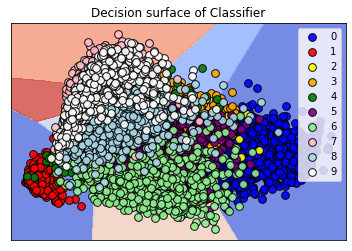

In [66]:
reduct = PCA(n_components = 2)

pca_X_train = reduct.fit_transform(X_train)


edc.fit(pca_X_train, y_train)
plot_clf(edc, pca_X_train, y_train, [i for i in range(10)])

γ) Σχεδιάστε την καμπύλη εκμάθησης του ευκλείδειου ταξινομητή (learning curve)


In [67]:
def plot_learning_curve(train_scores, test_scores, train_sizes, ylim=(0, 1)):
    plt.figure()
    plt.title("Learning Curve")
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="blue",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="orange",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

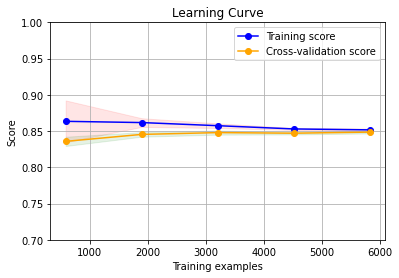

In [68]:
train_sizes, train_scores, test_scores = learning_curve(edc, X_train, y_train, cv = kf.split(train_arr), n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))

plot_learning_curve(train_scores, test_scores, train_sizes, ylim=(0.7, 1))

**ΒΗΜΑ 14**: Υπολογίστε τις a-priori πιθανότητες για κάθε κατηγορία (class priors).

Υπολογίζουμε τις a priori πιθανότητες για κάθε κλάση, δηλαδή απτο y_train για κάθε label βρίσκουμε το P(Yc) = number of samples with label c/ total samples

---
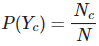



---

όπου Nc το πλήθος των samples που ανήκουν στη κλάση c και Ν το συνολικό πλήθος των samples στο y_train

Προφανώς, περιμένουμε το άθροισμά τους να κάνει 1


In [69]:
total_priori = []
for digit in range(10):
  frequency = 0
  priori = 0
  for j,y in enumerate(y_train):
    if y == digit:
      frequency += 1
  priori = frequency/len(y_train)
  total_priori.append(priori)

for i in range(10):
  print("A priori for " + str(i) + " = " + str(total_priori[i]))

A priori for 0 = 0.16376354409546015
A priori for 1 = 0.13784117405019888
A priori for 2 = 0.10026059525442327
A priori for 3 = 0.09024825126868742
A priori for 4 = 0.08942531888629818
A priori for 5 = 0.07625840076807022
A priori for 6 = 0.09107118365107666
A priori for 7 = 0.08846523110684405
A priori for 8 = 0.07433822520916199
A priori for 9 = 0.08832807570977919


**ΒΗΜΑ 15**: Ταξινομήστε όλα τα ψηφία των test δεδομένων ως προς τις 10 κατηγορίες χρησιμοποιώντας τις τιμές της
μέσης τιμής και διασποράς που υπολογίσατε στο Βήμα 9(α), υλοποιώντας έναν Naive Bayesian ταξινομητή




> Οι ταξινομητές Naive Bayes είναι ένα σύνολο supervised αλγορίθμων εκμάθησης βασισμένοι στο θέωρημα Bayes 

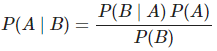

κάνοντας την "αφελή" υπόθεση ότι τα features είναι ανεξάρτητα.

​Με δεδομένα μια μεταβλητή κατηγορίας (κλάσης) y και ένα εξαρτώμενο διάνυσμα χαρακτηριστικών x1 μέχρι xn, σύμφωνα με το θεώρημα του Bayes θα ισχύει:

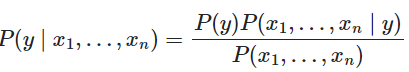

Χρησιμοποιώντας την naive υπόθεση, η παραπάνω σχέση καταλήγει στην 

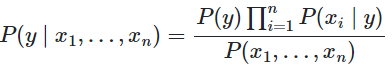

και καθώς ο παρονομαστής είναι σταθερός, καταλήγουμε στη σχέση

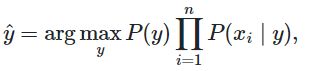

Το P(y) είναι η υπόθεσή μας και ισούται με τη σχετική συχνότητα του label y στο training set (βρέθηκε στο βήμα 14). Το P(xi|y) είναι η πιθανότητα του δείγματος με δεδομένη την υπόθεσή μας και μπορεί επίσης να υπολογιστεί απλά από το training set.



> Η διαφορά στους διάφορους Naive Bayes ταξινομητές είναι στην υπόθεση που κάνουν σχετικά με τη κατανομή της P(xi|y)

​Στην περίπτωσή μας τα χαρακτηριστικά (τιμές pixels) παίρνουν συνεχείς τιμές, οπότε θα υλοποιήσουμε έναν Gaussian Naive Bayes, όπου η πιθανοφάνεια των features υποτίθεται ότι είναι Gaussian, δηλαδή:

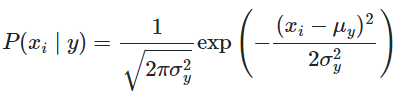

Επειδή η διασπορά υπάρχει στον παρονομαστή της συνάρτησης πυκνότητας, για να αποφύγουμε μηδενισμούς της. προσθέτουμε σε όλες τις αποκλίσεις ένα κοινό μικρό offset της τάξης του 10^-9. Παρακάτω θα δείξουμε κιόλας πως για διάφορες τιμές αυτού του offset λαμβάνουμε και διαφορετικά αποτελέσματα στο score.

**Παρατηρήσεις κώδικα:** 

**1)Μέσα στη μέθοδο fit για τον υπολογισμό της a priori πιθανότητας κάθε κλάσης χρησιμοποιήσαμε τη μέθοδο numpy.bincount η οποία επιστρέφει τις συχνότητες εμφάνισεις κάθε πιθανού sample τις οποίες μετά διαιρούμε με τον συνολικό αριθμό των samples. Στο βήμα 14, για να αποφύγουμε τη χρήση αυτής της έτοιμης συνάρτησης παραθέσαμε έναν δικό μας απλό κώδικα. Και οι δύο εκτελέσεις έχουν τα ίδια αποτελέσματα.**


**2)Παιρνώντας στη συνάρτηση argmax ως παράμετρο το result ήρθαμε αντιμέτωποι για το β ερώτημα με το error: operands could not be broadcast together with shapes (10,2007) (10,). Ψάχνοντας στο διαδίκτυο, βρήκαμε ότι φταίει η διάσταση του πίνακα και μια λύση είναι να περάσουμε τον transpose του (result.T)**









In [70]:
class CustomNBClassifier(BaseEstimator, ClassifierMixin):
    """Custom implementation Naive Bayes classifier"""

    def __init__(self):
        self.X_mean_ = None  #Mean value
        self.X_var_ = None   #Variance
        self.prior = None    #prior probability
        self.n_classes = None  #number of classes

    def fit(self, X, y):
        # Take the number of samples and features of train size
        train_size, n_features = X.shape 

        self.n_classes = len(np.unique(y))
        # Initialize mean and variance arrays
        self.X_mean_ = np.zeros((self.n_classes, n_features))
        self.X_var_ = np.zeros((self.n_classes, n_features))

        # Compute mean and variance values for each class
        for x in range(self.n_classes):
            # Take indices of all samples for each class/label
            idx_i = [i for i in range(train_size) if y[i] == x]
            # Keep only the features for the selected samples
            X_k = np.take(X, idx_i, axis=0)

            self.X_mean_[x, :] = np.mean(X_k, axis=0, keepdims=True)
            self.X_var_[x, :] = np.var(X_k, axis=0, keepdims=True)
        
        # Compute prior probabilities for each class
        # Bincount counts number of occurrences of each value in array of non-negative ints
        self.prior = np.bincount(y) / train_size
        
        return self


    def predict(self, X):
      # For storing the product of all probabilities P(xi|y)
      result = np.zeros((self.n_classes, len(X)))
      # Define e for calculation stability (division by zero). 
      # Changing this variable we get different scoring results
      offset = 10**(-9)
      # For each class compute the equation 1/sqrt(2pi*variance)*exp(-(feature - mean value)^2 / 2*variance)
      for i in range(self.n_classes):
          result[i] = np.prod((1/(np.sqrt(2*np.pi*(self.X_var_[i]+ offset)))) * np.exp(-0.5*((X - self.X_mean_[i])**2 / (self.X_var_[i] + offset))), axis=1)
      # Classify to the best result(max) of P(y)*product(P(xi|y))
      return np.argmax(result.T * self.prior, axis=1)
    
      def score(self, X, y):
        corr = 0
        y_pred = self.predict(X)
        corr = sum(int(y[i] == y_pred[i]) for i in range(len(y)))
        acc = corr / len(y)
        return acc

Εφαρμόζουμε τον εκτιμητή Naive Bayes στη πράξη

In [71]:
nb = CustomNBClassifier()
nb.fit(X_train, y_train)
y_predict = nb.predict(X_test)
print(y_predict)

[9 6 3 ... 9 0 1]


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


β)Υπολογίστε το σκορ για το Βήμα 15(α)

In [72]:
print("Score: " + str(nb.score(X_test, y_test)))

Score: 0.7199800697558545


Όπως ειπώθηκε και προηγουμένως, πειραματιζόμενοι με διάφορες του offset, δηλαδή της τιμής που προστίθεται στη διασπορά για αποφυγή του μηδενισμού της, λαμβάνουμε διαφορετικές τιμές του score, τις οποίες συνοψίζουμε στον παρακάτω πίνακα.



> 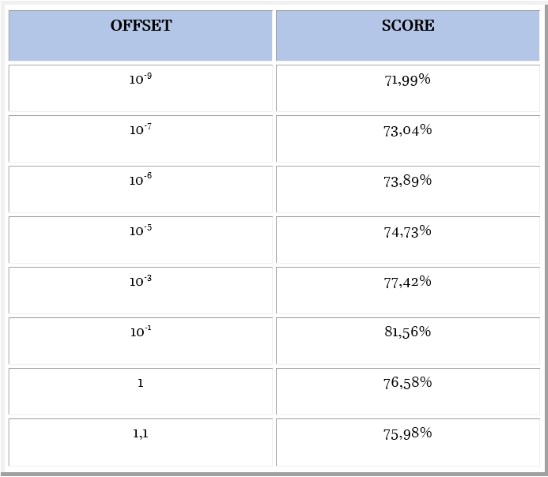

*Παρατηρούμε πως καθώς αυξάνεται η τιμή του offset απο το 10^-9, η απόδοση του μοντέλου μας αυξάνεται και το score επιφέρει καλύτερα αποτελέσματα μέχρι τη τιμή 1 όπου απο εκεί και πέρα, με την αύξηση του offset η απόδοση πέφτει.*

γ)Συγκρίνετε την υλοποίηση σας του Naive Bayes με την υλοποίηση του scikit-learn (GaussianNB)

In [73]:
gauss = GaussianNB()

gauss.fit(X_train, y_train)

print("Accuracy of sklearn GaussianNB classifier")
print()

print(gauss.score(X_test, y_test))

Accuracy of sklearn GaussianNB classifier

0.7194818136522172


Παρατηρούμε ότι οι δύο υλοποιήσεις είναι πολύ κοντά μεταξύ τους, ωστόσο όπως είδαμε αν αλλάξουμε τον παράγοντα offset που προσθέτουμε στη διακύμανση η υλοποίησή μας του Naive Bayes είναι ικανή να παράγξει καλύτερα αποτελέσματα.


**ΒΗΜΑ 16**: Επαναλάβατε το Βήμα 15(α), (β) υποθέτοντας ότι η διασπορά για όλα τα χαρακτηριστικά, για όλες τις
κατηγορίες ισούται με 1



> Αντιγράφουμε τον κώδικα του ερωτήματος 15 α και β, χρησιμοποιώντας πλέον ως X_var έναν numpy array άσσων με διαστάσεις (n_classes, n_features)



In [74]:
class CustomNBClassifier2(BaseEstimator, ClassifierMixin):
    """Custom implementation Naive Bayes classifier"""

    def __init__(self, use_unit_variance=False):
        self.X_mean_ = None  #Mean value
        self.X_var_ = None   #Variance
        self.prior = None    #prior probability
        self.n_classes = None  #number of classes

    def fit(self, X, y):
        # Take the number of samples and features of train size
        train_size, n_features = X.shape 

        self.n_classes = len(np.unique(y))
        # Initialize mean and variance arrays
        self.X_mean_ = np.zeros((self.n_classes, n_features))

        # Variance is equal to 1.
        self.X_var_ = np.ones((self.n_classes, n_features))

        # Compute mean and variance values for each class
        for x in range(self.n_classes):
            # Take indices of all samples for each class/label
            idx_i = [i for i in range(train_size) if y[i] == x]
            # Keep only the features for the selected samples
            X_k = np.take(X, idx_i, axis=0)
            self.X_mean_[x, :] = np.mean(X_k, axis=0, keepdims=True)
        
        # Compute prior probabilities for each class
        # Bincount counts number of occurrences of each value in array of non-negative ints
        self.prior = np.bincount(y) / train_size
        
        return self


    def predict(self, X):
      # For storing the product of all probabilities P(xi|y)
      result = np.zeros((self.n_classes, len(X)))
      
      # For each class compute the equation 1/sqrt(2pi*variance)*exp(-(feature - mean value)^2 / 2*variance)
      for i in range(self.n_classes):
          result[i] = np.prod((1/(np.sqrt(2*np.pi*(self.X_var_[i])))) * np.exp(-0.5*((X - self.X_mean_[i])**2 / (self.X_var_[i]))), axis=1)
      # Classify to the best result(max) of P(y)*product(P(xi|y))
      return np.argmax(result.T * self.prior, axis=1)
    
      def score(self, X, y):
        corr = 0
        y_pred = self.predict(X)
        corr = sum(int(y[i] == y_pred[i]) for i in range(len(y)))
        acc = corr / len(y)
        return acc

Υπολογίζουμε το score του Naive Bayes εκτιμητή με την υπόθεση ότι η διασπορά για όλες τις κλάσεις ισούται με 1

In [75]:
nb2 = CustomNBClassifier2()
nb2.fit(X_train, y_train)

print("Score: " + str(nb2.score(X_test, y_test)))

Score: 0.8126557050323866


Παρατηρούμε ότι με αυτή την υπόθεση λαμβάνουμε καλύτερα αποτελέσματα

**ΒΗΜΑ 17**:Συγκρίνετε την επίδοση των ταξινομητών Naive Bayes, Nearest Neighbors, SVM (με διαφορετικούς kernels).
Μπορείτε να χρησιμοποιήσετε τις υλοποιήσεις του scikit-learn

In [76]:
#Ορισε σκορ για 

#1.NearestNeighbors
KN_5 = KNeighborsClassifier(n_neighbors=5)
KN_5.fit(X_train, y_train)

KN_10 = KNeighborsClassifier(n_neighbors=10)
KN_10.fit(X_train, y_train)

print("Accuracy of Nearest Neihbors classifier with different number of neighbors")
print()

print("Neighbors = 5: " + str(KN_5.score(X_test, y_test)))
print("Neighbors = 10: " + str(KN_10.score(X_test, y_test)))

KN_2 = KNeighborsClassifier(n_neighbors=2)
KN_2.fit(X_train, y_train)

print()
print("Just for testing purposes, accuracy considering 2 neighbors is: " + str(KN_2.score(X_test, y_test)))

Accuracy of Nearest Neihbors classifier with different number of neighbors

Neighbors = 5: 0.9446935724962631
Neighbors = 10: 0.9357249626307922

Just for testing purposes, accuracy considering 2 neighbors is: 0.9412057797708022


In [77]:
#SVM
SVM_linear = SVC(kernel="linear")  
SVM_linear.fit(X_train, y_train)

SVM_poly = SVC(kernel="poly")  
SVM_poly.fit(X_train, y_train)

SVM_rbf = SVC(kernel="rbf")  
SVM_rbf.fit(X_train, y_train)

SVM_sigm = SVC(kernel="sigmoid") 
SVM_sigm.fit(X_train, y_train)

print("Accuracy of SVM classifier with different kernels")
print()

print("Kernel = linear: " + str(SVM_linear.score(X_test, y_test)))
print("Kernel = poly: " + str(SVM_poly.score(X_test, y_test)))
print("Kernel = rbf: " + str(SVM_rbf.score(X_test, y_test)))
print("Kernel = sigmoid: " + str(SVM_sigm.score(X_test, y_test)))


Accuracy of SVM classifier with different kernels

Kernel = linear: 0.9262580966616841
Kernel = poly: 0.953662182361734
Kernel = rbf: 0.9471848530144494
Kernel = sigmoid: 0.8505231689088192


Στο παρακάτω πίνακα συγκρίνουμε τους ταξινομητές εμφανίζοντας τα score τους σε αύξουσα σειρά. Συγκρίνουμε τους παρακάτω ταξινομητές που υλοποιήθηκαν στα προηγούμενα βήματα: Custom_NaiveBayes, GaussianNB( o naive bayes της sklearn), Custom_NaiveBayes_var1 (o naive bayes με διασπορά 1), Nearest Neighbors, SVM

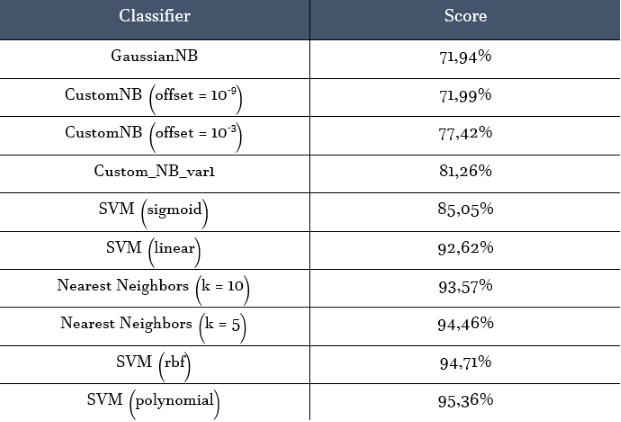



**ΒΗΜΑ 18**: Επιλέξτε κάποιους από τους ταξινομητές που χρησιμοποιήσατε στα προηγούμενα βήματα. Χρησιμοποιήστε
το VotingClassifier του scikit-learn για να τους συνδυάσετε σε hard ή soft voting. Αυτός ο μετα-ταξινομητής
συνδυάζει τους επιμέρους ταξινομητές βάζοντάς τους να ψηφίσουν για το αποτέλεσμα

Αρχικά ορίζουμε τη συνάρτηση compare η οποία κάνει ουσιαστικά το αντίθετο της μεθόδου score και υπολογίζει τα λανθασμένα predictions ενός ταξινομητή για κάθε κλάση. Αυτή θα μας βοηθήσει να βρούμε ποιοί ταξινομητές που συναντήσαμε προηγουμένως έχουν διαφορετικό τύπο λαθών.

In [78]:
def compare_scores(classifier):
  comp_score = []
  for digit in range(10): 
    indx_test = [i for i in range(n_samples_test) if y_test[i] == digit]

    X_test_tst = np.take(X_test, indx_test, axis=0)
    y_test_tst = np.take(y_test, indx_test, axis=0)

    classifier.fit(X_train, y_train)
    
    comp_score.append(classifier.score(X_test_tst, y_test_tst)) 

  return comp_score

Στη συνέχεια υπολογίζουμε τα score κάθε κλάσης απο όλους τους προηγούμενους ταξινομητές. Ουσιαστικά, ψάχνουμε να βρούμε αν το χαμηλότερο score που έχει ένας ταξινομητής για μια κλάση, το έχει και κάποιος άλλος για την ίδια αυτή κλάση. Αν ισχύει κάτι τέτοιο, οι δύο αυτοί ταξινομητές δεν πρέπει να επιλεχθούν μαζί για το ensembling.

In [79]:
test_scores = np.zeros((4,10))

#Euclidean
euclTest = EuclideanDistanceClassifier()
#CustomNB
nbTest = CustomNBClassifier()
#GaussianNB
gbTest = GaussianNB()
#Nearest Neighbors
knnTest = KNeighborsClassifier(n_neighbors=5)
#SVM
svmTest = SVC(kernel="poly", probability=True)

model = [euclTest, nbTest, knnTest, svmTest]

for i in range(4):
  test_scores[i] = compare_scores(model[i])

print(test_scores*100)



 

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce

[[82.72980501 98.10606061 73.23232323 78.91566265 75.         76.875
  84.11764706 79.59183673 77.10843373 79.66101695]
 [82.72980501 97.34848485 70.70707071 47.59036145 28.         45.
  88.82352941 88.43537415 66.26506024 86.44067797]
 [98.60724234 98.10606061 91.91919192 92.77108434 91.5        90.
  95.88235294 93.87755102 90.96385542 94.91525424]
 [98.88579387 97.34848485 93.43434343 90.96385542 94.5        93.75
  95.29411765 94.55782313 93.97590361 96.04519774]]


Με μια πρώτη ματιά, παίρνουμε την απόφαση να χρησιμοποιήσουμε τους ταξινομητές Euclidean, Naive Bayes, SVM και όχι τον Nearest Neighbors διότι ο τελευταίος έχει παρόμοιo accuracy για κάθε κλάση με τον SVM που σημαίνει ότι δεν θα διαφοροποιείται η ψήφος τους στο voting άρα δεν θα παίρνουμε αντικειμενικό αποτέλεσμα.




> *Είναι σημαντικό να επιλεχθεί μονός αριθμός ταξινομητών έτσι ώστε να μη προκύψει ισοπαλία στο voting*



In [80]:
estimator = [('eucl',euclTest), ('nb',nbTest), ('svm',svmTest)]

# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = estimator, voting ='hard', flatten_transform=True)
vot_hard.fit(X_train, y_train)
  
# using accuracy_score metric to predict accuracy
score = vot_hard.score(X_test, y_test)
print("Hard Voting Score: " + str(score))

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Hard Voting Score: 0.8873941205779771


Δοκιμάζοντας διαφορετικούς συνδυασμούς ταξινομητών για τον VotingClassifier καταλήγουμε στα συμπεράσματα τα οποία συνοψίζονται στο εξής γράφημα

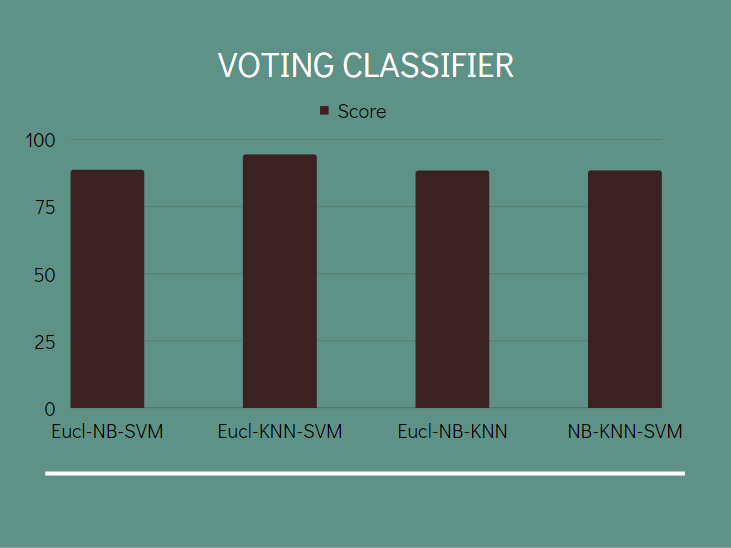

β)Επιλέξτε έναν ταξινομητή από τα προηγούμενα βήματα και χρησιμοποιήστε τον BaggingClassifier για να
δημιουργήσετε ένα ensemble

In [81]:
bagging = BaggingClassifier(base_estimator = svmTest, n_estimators=10)
bagging.fit(X_train, y_train)
print(bagging.score(X_test, y_test))

0.9501743896362731


γ) Τον σχολιασμό των αποτελεσμάτων τον αναπτύσσουμε εκτενέστερα στην αναφορά του εργαστηρίου που επισυνάπτουμε.

**ΒΗΜΑ 19**

α)

Υλοποιήστε έναν dataloader για να αναλάβει την ανάγνωση των δεδομένων και τον χωρισμό σε batches



> Αρχικά υλοποιούμε ένα CustomDataset το οποίο κληρονομεί τη κλάση Dataset της PyTorch αλλά κάνει override της μεθόδους len() και getitem()



In [82]:
class CustomDataset(Dataset):
  
  def __init__(self, X, y):
      
      self.data = X #samples
      self.labels = y #labels

  def __len__(self):
    
    #return the length of the dataset
    return len(self.data)

  def __getitem__(self, idx):
        
    #Returns the idx-th item from the dataset
    return self.data[idx], self.labels[idx]

*Παρακάτω ζητείται ο χωρισμός των training δεδομένων σε train και validation οπότε για ευκολία υλοποιούμε το βήμα αυτό εξαρχής σε αυτή τη φάση. Χρησιμοποιούμε διαχωρισμό 80/20 που σημαίνει ότι το 80% των training δεδομένων θα κρατηθεί για το train και το 20% των δεδομένων θα κρατηθεί για το validation*

In [83]:
X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(X_train, y_train, test_size=0.2)

train_set = CustomDataset(X_train_s, y_train_s)
val_set = CustomDataset(X_val_s, y_val_s)
test_set = CustomDataset(X_test, y_test)

print("Train size is :" + str(len(train_set)))
print("Validation size is :" + str(len(val_set)))
print("Test size is :" + str(len(test_set)))


Train size is :5832
Validation size is :1459
Test size is :2007


Στη συνέχεια ορίζουμε τους dataloader για κάθε ένα σύνολο δεδομένων. Για τον DataLoader ορίζουμε ως batch_size=32 κάτι που συμβουλευτήκαμε απο το διαδίκτυο. Άλλη επιλογή ήταν η τιμή 64 και γενικά μικρές τιμές πολλαπλάσια του 2.
Περνώντας ως τιμή για το num_workers=4, λάβαμε το εξής σφάλμα: 

*This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2*

Οπότε θα χρησιμοποιήσουμε τη τιμή 2

In [84]:
train_loader = DataLoader(train_set, batch_size=32,
                          shuffle=True, num_workers=2)

val_loader = DataLoader(val_set, batch_size=32,
                          shuffle=True, num_workers=2)

test_loader = DataLoader(test_set, batch_size=32,
                          shuffle=True, num_workers=2)

β)

Υλοποιήστε ένα fully connected νευρωνικό δίκτυο σε PyTorch σαν μια υποκλάση της nn.Module. και
εκπαιδεύστε το στα δεδομένα. Πειραματιστείτε με τον αριθμό των νευρώνων, τον αριθμό των layers και τον
τύπο των μη γραμμικών actications

Απο τις activation functions της PyTorch θα πειραματιστούμε με τις συναρτήσεις:
1.ReLu
2.Sigmoid
3.Tanh

Επίσης, για να βρούμε το optimal structure του νευρωνικού μας δικτύου θα δοκιμάσουμε διάφορους αριθμούς νευρώνων αλλά και layers.

Γενικά θα πειραματιστούμε με ένα και δύο hidden layers.

*Στο βιβλίο Introduction to Neural Networks for Java, Second Edition by jeffheaton, αναφέρεται ότι ο αριθμός των hidden layers καθορίζεται απο τα εξής:*

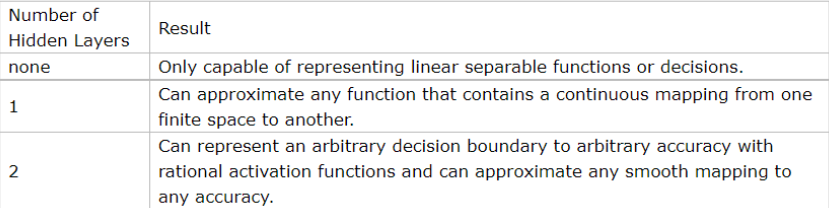

Γενικά όσο αυξάνεται ο αριθμός των layers τόσο αυξάνεται και ο κίνδυνος του overfitting οπότε είναι καλό να πειραματιζόμαστε μέχρι ένα σημείο.

Στη συνέχει πρέπει να αποφασίσουμε τον αριθμό των νευρώνων που θα περίεχει κάθε hidden layes. Αρχικά ο αριθμός των νευρώνων στα hidden layeres πρέπει να είναι ανάμεσα στο μέγεθος του input layer και του output layer και καθώς προχωράνε τα hidden layers ο αριθμός των νευρώνων να μειώνεται. Επομένως πειραματιζόμαστε με διάφορους αριθμούς μέσα σαυτά τα όρια προσπαθώντας να πετύχουμε καλύτερα αποτελέσματα

Αρχικά ορίζουμε ένα νευρωνικό δίκτυο δύο επιπέδων (ένα hidden layer) με activation function ReLu

In [85]:
# 2-layer NN with ReLu

class TwoLayerNetwork(torch.nn.Module):
    def __init__(self, D_in, Hid, D_out):
        super(TwoLayerNetwork, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, Hid) #input 
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(Hid, D_out) #output
        

    # How forwarding the information is done
    def forward(self, data):
        hidden =  self.relu(self.linear1(data.float())) # Output of first layer 
        preds = self.linear2(hidden) #Ouput of second layer, which is also the prediction of out Neural Network
        return preds

Συγκεκριμένα, ορίζουμε ως D_in τον αριθμό των νευρώνων στο input layer (εφόσον έχουμε 256 features αυτός ο αριθμός θα είναι 256), D_out τον αριθμό νευρώνων στο output layer και Hid είναι ο αριθμός νευρώνων στο hidden layer. 

Εφόσον υλοποιούμε ένα fully-connected δίκτυο θα χρησιμοποιήσουμε linear layers. Linear layer είναι ένα module της PyTorch που εφαρμόζει ένα γραμμικό μετασχηματισμό στην είσοδο χρησιμοποιώντας τα αποθηκευμένα weights και biases.

Στη μέθοδο forward γίνονται όλοι οι υπολογισμοί, δέχεται ως είσοδο ένα tensor απο δεδομένα και έχει ως έξοδο ένα tensor από δεδομένα. Στη μεταβλητή hidden αποθηκεύουμε την έξοδο της ReLu η οποία αντικαθιστά ουσιαστικά όλα τα αρνητικά στοιχεία του tensor που παίρνει ως είσοδο με μηδέν και τα υπόλοιπα μένουν ανεπηρέαστα. 

Ύστερα αποθηκεύουμε την έξοδο του output layer που παίρνει ως είσοδο την έξοδο του hidden layer.

Ορίσαμε ως τύπο float τα data διότι σε διαφορετική περίπτωση λαμβάναμε σφάλμα: expected scalar type Float but found Double




> Παρακάτω ακολουθούμε την ίδια διαδικασία για να ορίσουμε τα μοντέλα μας με διαφορετικό αριθμό layers και διαφορετικές activation functions



In [86]:
# 3-Layer NN with ReLu

class ThreeLayerNetwork(torch.nn.Module):
    def __init__(self, D_in, Hid1, Hid2, D_out):
        super(ThreeLayerNetwork, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, Hid1) #input 
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(Hid1, Hid2) 
        self.linear3 = torch.nn.Linear(Hid2, D_out) #output
        

    def forward(self, data):
        hidden1 =  self.relu(self.linear1(data.float()))
        hidden2 =  self.relu(self.linear2(hidden1))
        preds = self.linear3(hidden2)
        return preds

In [87]:
# 2-Layer NN with Sigmoid

class TwoLayerNetwork_S(torch.nn.Module):
    def __init__(self, D_in, Hid, D_out):
        super(TwoLayerNetwork_S, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, Hid) #input 
        self.sigmoid = torch.nn.Sigmoid()
        self.linear2 = torch.nn.Linear(Hid, D_out) #output
        

    def forward(self, data):
        hidden =  self.sigmoid(self.linear1(data.float()))
        preds = self.linear2(hidden)
        return preds

In [88]:
# 3-Layer NN with Sigmoid

class ThreeLayerNetwork_S(torch.nn.Module):
    def __init__(self, D_in, Hid1, Hid2, D_out):
        super(ThreeLayerNetwork_S, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, Hid1) #input 
        self.sigmoid = torch.nn.Sigmoid()
        self.linear2 = torch.nn.Linear(Hid1, Hid2) 
        self.linear3 = torch.nn.Linear(Hid2, D_out) #output
        

    def forward(self, data):
        hidden1 =  self.sigmoid(self.linear1(data.float()))
        hidden2 = self.sigmoid(self.linear2(hidden1))
        preds = self.linear3(hidden2)
        return preds

In [89]:
# 2-Layer NN with tanh

class TwoLayerNetwork_t(torch.nn.Module):
    def __init__(self, D_in, Hid, D_out):
        super(TwoLayerNetwork_t, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, Hid) #input 
        self.tanh = torch.nn.Tanh()
        self.linear2 = torch.nn.Linear(Hid, D_out) #output
        

    def forward(self, data):
        hidden =  self.tanh(self.linear1(data.float()))
        preds = self.linear2(hidden)
        return preds

In [90]:
# 3-Layer NN with tanh

class ThreeLayerNetwork_t(torch.nn.Module):
    def __init__(self, D_in, Hid1, Hid2, D_out):
        super(ThreeLayerNetwork_t, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, Hid1) #input 
        self.tanh = torch.nn.Tanh()
        self.linear2 = torch.nn.Linear(Hid1, Hid2) 
        self.linear3 = torch.nn.Linear(Hid2, D_out) #output
        

    def forward(self, data):
        hidden1 =  self.tanh(self.linear1(data.float()))
        hidden2 = self.tanh(self.linear2(hidden1))
        preds = self.linear3(hidden2)
        return preds

Έχουμε υλοποιήσει λοιπόν 6 διαφορετικά μοντέλα, τα οποία ο χρήστης τώρα με βάση την είσοδο του θα μπορεί να διαλέξει και να ελέγξει τα αποτελέσματα.

Όπως είπαμε το D_in μας είναι 256 όσα και τα features, και το D_out θα είναι 10, όσες και οι διαφορετικές κλάσεις μας.

Aναλυτικός σχολιασμός του κώδικα αλλά και των αποτελεσμάτων γίνεται στην αναφορά.

>*Μερικά σημεία κώδικα χρησιμοποιήθηκαν απο το tutorial: Training a classifier της επίσημης σελίδας της PyTorch*





In [91]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

D_in, D_out = 256, 10


#Choose how many layers you want
layers = int(input("Number of hidden layers: (1 or 2)")) 
#Choose how many neurons you need
if layers == 1:
    size1 = int(input("Size of hidden layer: ")) 
    size2 = None
else:
    size1 = int(input("Size of 1st hidden layer: "))
    size2 = int(input("Size of 2nd hidden layer: "))

#Select type of activation function
activation = input("Activation function: (relu, sigmoid or tanh)")

if layers == 1:
    if activation == "relu":
        model = TwoLayerNetwork(D_in, size1, D_out)
    elif activation == "sigmoid":
        model = TwoLayerNetwork_S(D_in, size1, D_out)
    elif activation == "tanh":
        model = TwoLayerNetwork_t(D_in, size1, D_out)
else:
    if activation == "relu":
        model = ThreeLayerNetwork(D_in, size1, size1, D_out)
    elif activation == "sigmoid":
        model = ThreeLayerNetwork_S(D_in, size1, size2, D_out)
    elif activation == "tanh":
        model = ThreeLayerNetwork_t(D_in, size1, size2, D_out)



# Start Training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

prev_val = 0 # For control of the number of epochs
ep = 1 # We start at epoch number 1
 
while True:
    print("Epoch: " + str(ep))
    
    # Train and evaluate on train set
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        
        # Print Statistics
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    
    print('Accuracy in train: %f %%' % (
            100 * correct_train / total_train))
    
    # Evaluate on validation set
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in  val_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    print('Accuracy in val: %f %%' % (
            100 * correct_val / total_val))
    
    # Stop when validation accuracy stops increasing.
    curr_val = correct_val / total_val
    if curr_val < prev_val:
        break
    prev_val = curr_val
    ep += 1
    
print('Finished Training')

Number of hidden layers: (1 or 2)2
Size of 1st hidden layer: 100
Size of 2nd hidden layer: 50
Activation function: (relu, sigmoid or tanh)tanh
Epoch: 1
Accuracy in train: 44.272977 %
Accuracy in val: 59.629883 %
Epoch: 2
Accuracy in train: 70.901920 %
Accuracy in val: 79.643592 %
Epoch: 3
Accuracy in train: 84.447874 %
Accuracy in val: 87.183002 %
Epoch: 4
Accuracy in train: 89.180384 %
Accuracy in val: 89.444825 %
Epoch: 5
Accuracy in train: 90.929355 %
Accuracy in val: 91.295408 %
Epoch: 6
Accuracy in train: 91.889575 %
Accuracy in val: 91.569568 %
Epoch: 7
Accuracy in train: 92.592593 %
Accuracy in val: 92.392049 %
Epoch: 8
Accuracy in train: 93.175583 %
Accuracy in val: 92.392049 %
Epoch: 9
Accuracy in train: 93.364198 %
Accuracy in val: 92.666210 %
Epoch: 10
Accuracy in train: 93.895748 %
Accuracy in val: 93.077450 %
Epoch: 11
Accuracy in train: 94.050069 %
Accuracy in val: 93.145990 %
Epoch: 12
Accuracy in train: 94.427298 %
Accuracy in val: 93.420151 %
Epoch: 13
Accuracy in trai

Είμαστε έτοιμοι να τεστάρουμε το μοντέλο που διαλέξαμε προηγουμένως στα test δεδομένα βλέποντας το accuracy του σε όλο το σύνολο των δεδομένων αλλά και σε κάθε κλάση ξεχωριστά

In [92]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


print(f'Accuracy of the network: {100 * correct // total} %')
print() 

print("Accuracy of the network for each and every class")
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the network: 90 %

Accuracy of the network for each and every class
Accuracy for class: 0     is 96.4 %
Accuracy for class: 1     is 94.3 %
Accuracy for class: 2     is 83.8 %
Accuracy for class: 3     is 86.1 %
Accuracy for class: 4     is 90.5 %
Accuracy for class: 5     is 87.5 %
Accuracy for class: 6     is 94.1 %
Accuracy for class: 7     is 90.5 %
Accuracy for class: 8     is 84.9 %
Accuracy for class: 9     is 92.7 %


γ)

Γράψτε τον κώδικα για την εκπαίδευση και το evaluation του νευρωνικού ,συμβατή με το scikit-learn

Όπως είδαμε και στο βήμα 12, τα μοντέλα της sklearn ακολουθούν συγκεκριμένους κανόνες. Ουσιαστικά αυτό που καλούμαστε να κάνουμε, είναι να υλοποιήσουμε τις μεθόδους init, fit και score.

Ορίζουμε το sklearn νευρωνικό δίκτυο με ένα hidden layer και συνάρτηση ενεργοποίησης tanh

In [93]:
class NN(BaseEstimator, ClassifierMixin):  

    def __init__(self, D_in, D_out, Hid, batch_size):
        self.D_in = D_in
        self.D_out = D_out
        self.H = Hid
        self.batch_size = batch_size
        self.model = TwoLayerNetwork_t(self.D_in, self.H, self.D_out)


    def fit(self, X, y):

        '''
        Here we fit our custom model. Basically we just copied all the 
        computations that were done in while(True) loop'''

        # Splitting the train data into training and validation
        X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(X, y, test_size=0.2)

        self.train_set = CustomDataset(X_train_s, y_train_s)
        self.val_set = CustomDataset(X_val_s, y_val_s)

        train_loader = DataLoader(self.train_set, batch_size=self.batch_size,
                          shuffle=True, num_workers=2)
        val_loader = DataLoader(self.val_set, batch_size=self.batch_size,
                          shuffle=True, num_workers=2)
        
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

        prev_val = 0
        ep = 1

        while True:
            print("Epoch: " + str(ep))
            correct_train = 0
            total_train = 0
            for i, data in enumerate(train_loader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.model(inputs)

                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()


            print('Accuracy in train: %f %%' % (
                    100 * correct_train / total_train))

            correct_val = 0
            total_val = 0
            with torch.no_grad():
                for data in val_loader:
                    images, labels = data
                    outputs = self.model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

            print('Accuracy in val: %f %%' % (
                    100 * correct_val / total_val))

            curr_val = correct_val / total_val
            if curr_val < prev_val:
                break
            prev_val = curr_val
            ep += 1
        
        return self


    
    def score(self, X, y):
        """
        Return accuracy score on the predictions
        for X based on ground truth y.

        """
        test_set = CustomDataset(X, y)
        test_loader = DataLoader(test_set, batch_size=self.batch_size, num_workers=2)
        
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        return correct/total

In [ ]:
NN_sk = NN(256, 10, 128, 32)

NN_sk.fit(X_train, y_train)

δ)

Αξιολογήστε την επίδοση του νευρωνικού στα δεδομένα test.

In [95]:
print(NN_sk.score(X_test, y_test))

0.16292974588938713
